# 고양이 수염 스티커 만들기

## 1. 정면 사진 (test)

### (0) 스티커와 이미지 준비하기

스티커 : [고양이 수염 이미지](https://www.flaticon.com/free-icon/cat-whiskers_24674?term=cat%20nose&page=1&position=1, "cat-whiskerslink")

이미지 : 연예인 사진 사용

### (1) 필요 라이브러리 import

In [40]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import dlib
import math

print("슝~")

슝~


### (2) 이미지 불러오기

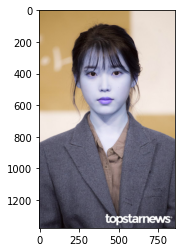

In [41]:
# opencv로 이미지 불러오기
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image1.jpg'
img_bgr = cv2.imread(my_image_path)

# img_bgr = cv2.resize(img_bgr, (500, 500))    # 500x500의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관

plt.imshow(img_bgr)
plt.show()

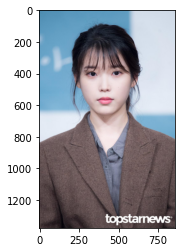

In [42]:
# opencv 는 RGB 대신 BGR 을 사용하기 때문에 RGB로 변경
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

### (3) 얼굴 검출 & 랜드마크 검출하기

### 얼굴 검출 Key point

Object detection 기술을 이용해서 얼굴의 위치를 찾는다.

dlib 의 face detector 는 HOG (Histogram of Oriented Gradient) feature를 사용해서 SVM (Support Vector Machine)의 sliding window로 얼굴을 찾습니다.

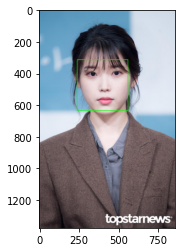

In [43]:
# HOG Detector 선언 (얼굴 위치 찾기 (Object detection))
detector_hog = dlib.get_frontal_face_detector()

# Bounding box 추출
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

# dlib_rect가 찾는 얼굴 영역 좌표
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### 얼굴 랜드마크 (Face Landmark) Key point

이목구비의 위치를 추론하는 것을 face landmark localization 기술이라고 합니다.
face landmark는 detection 의 결과물인 bounding box로 잘라낸 (crop) 얼굴 이미지를 이용한다.

    . Object keypoint estimation 알고리즘 : 객체 내부의 점을 찾는 기술
        1. top-down: bounding box를 찾고 box 내부의 keypoint를 예측
        2. bottom-up: 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화를 해서 box를 생성

68


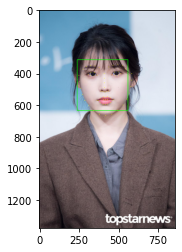

In [44]:
# landmark 모델 불러오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# landmark 찾기
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0])) # landmark 갯수 확인

# landmark 출력
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### (4) 스티커 적용 위치 확인하기


고양이 수염이 적용 될 볼 위치를 landmark를 사용해서 계산해 주세요.

볼은 '턱', '눈', '입', '코' 사이에 있다는 점을 이용해 주세요. 비율로 계산하는 방법 잊지 않으셨죠?

hint 2, 36, 48, 30 번 인덱스를 이용

In [45]:
# 좌표 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1]
    
    w = dlib_rect.width()
    h = dlib_rect.width()
    
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(414, 488)
(x,y) : (414,488)
(w,h) : (322,322)


(322, 322, 3)


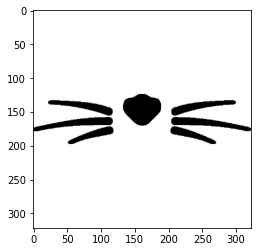

In [46]:
# 스티커 이미지 Read
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
plt.imshow(img_sticker)
print (img_sticker.shape)

In [47]:
# 스티커 이미지 좌표
refined_x = x - w // 2  # left
refined_y = y - h // 2 # top

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (253,327)


In [48]:
# y좌표가 음수일 때, -y만큼 이미지를 잘라준 후 y 경계값은 0으로 설정
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:]
    refined_y = 0
    
print (img_sticker.shape)
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(322, 322, 3)
(x,y) : (253,327)


### (5) 스티커 적용하기

(1) 오늘 배운 np.where 를 사용해서 스티커를 적용해 주세요.

(2) 스티커를 조금 더 자연스럽게 보이게 하려면 어떻게 해야 할까요? 스티커 뒤로 원본 이미지가 같이 보이도록 만들어 봅시다.

hint opencv 의 cv2.addWeighted() 를 참고하세요.

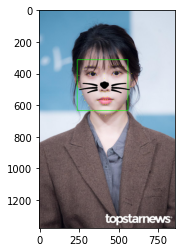

In [49]:
# 원본에 스티커 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

# 결과 이미지 출력
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### (6) 최종 이미지 출력 하기

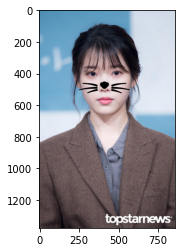

In [50]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255, sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### (7) 문제점 찾아보기

(1) 셀프 카메라를 다양한 각도에서 촬영하면서 스티커를 반복해서 적용해 보세요.

(2) 문제점이 무엇인지 최대한 자세하게 기록해 보세요. 여러분이 생각한 문제점을 해결하기 위한 방법은 분명 존재합니다!

# 2. 여러 종류의 이미지 테스트

### 2.1. 어두운 이미지

### 2.1.1 어두운 이미지의 사진 불러오기

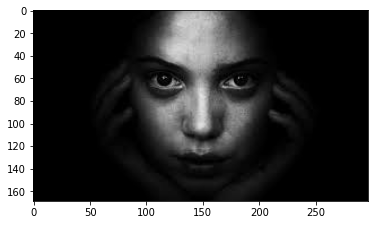

In [51]:
# opencv로 이미지 불러오기
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/dark_image1.png'
img_bgr = cv2.imread(my_image_path)

# img_bgr = cv2.resize(img_bgr, (500, 500))    # 500x500의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관

# opencv 는 RGB 대신 BGR 을 사용하기 때문에 RGB로 변경
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

### 2.1.2 얼굴 검출 & 랜드마크 검출하기

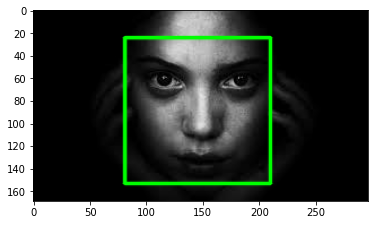

68


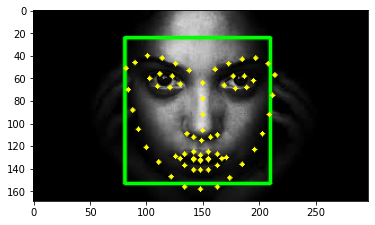

In [52]:
# HOG Detector 선언 (얼굴 위치 찾기 (Object detection))
detector_hog = dlib.get_frontal_face_detector()

# Bounding box 추출
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

# dlib_rect가 찾는 얼굴 영역 좌표
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# landmark 모델 불러오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# landmark 찾기
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0])) # landmark 갯수 확인

# landmark 출력
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### 2.1.3 스티커 적용 위치 확인 & 적용 하기

(150, 106)
(x,y) : (150,106)
(w,h) : (130,130)
(130, 130, 3)
(x,y) : (85,41)
(130, 130, 3)
(x,y) : (85,41)


ValueError: operands could not be broadcast together with shapes (130,130,3) (128,130,3) (130,130,3) 

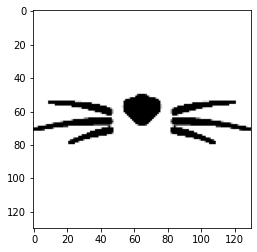

In [53]:
# 좌표 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1]
    
    w = dlib_rect.width()
    h = dlib_rect.width()
    
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))
    
# 스티커 이미지 Read
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
plt.imshow(img_sticker)
print (img_sticker.shape)

# 스티커 이미지 좌표
refined_x = x - w // 2  # left
refined_y = y - h // 2 # top

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

# y좌표가 음수일 때, -y만큼 이미지를 잘라준 후 y 경계값은 0으로 설정
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:]
    refined_y = 0
    
print (img_sticker.shape)
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

# 원본에 스티커 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

# 결과 이미지 출력
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 2.1.4 최종 이미지 출력 하기

In [54]:
# 원본에 스티커 적용
sticker_area = img_bgr[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

# 결과 이미지 출력
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

ValueError: operands could not be broadcast together with shapes (130,130,3) (128,130,3) (130,130,3) 

### 2.1.5 문제점

1번에서 적용했었던 코드를 그대로 진행 하였으나, 고양이 수염 이미지까지만, 로드가 되고

operands could not be broadcast together with shapes (130,130,3) (128,130,3) (130,130,3) 라는 경고문과 함께

고양이 수염이 적용 된 어두운 사진의 이미지가 적용되지 않습니다.

아마도 두 이미지의 블렌딩 과정에서 문제가 생긴 것 같은데...

어떻게 수정을 시도 해야할 지 모르겠습니다.

### 2.2. 비스듬한 각도의 이미지

### 2.2.1 비스듬한 각도의 이미지의 사진 불러오기

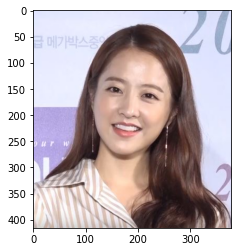

In [55]:
# opencv로 이미지 불러오기
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.jpg'
img_bgr = cv2.imread(my_image_path)

# img_bgr = cv2.resize(img_bgr, (500, 500))    # 500x500의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관

# opencv 는 RGB 대신 BGR 을 사용하기 때문에 RGB로 변경
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

### 2.2.2 얼굴 검출 & 랜드마크 검출하기

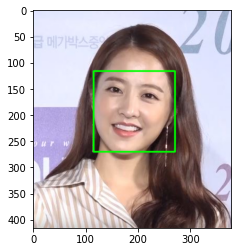

68


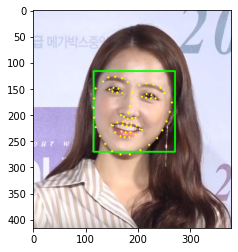

In [56]:
# HOG Detector 선언 (얼굴 위치 찾기 (Object detection))
detector_hog = dlib.get_frontal_face_detector()

# Bounding box 추출
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

# dlib_rect가 찾는 얼굴 영역 좌표
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# landmark 모델 불러오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# landmark 찾기
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0])) # landmark 갯수 확인

# landmark 출력
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### 2.2.3 스티커 적용 위치 확인 & 적용 하기

(182, 196)
(x,y) : (182,196)
(w,h) : (156,156)
(156, 156, 3)
(x,y) : (104,118)
(156, 156, 3)
(x,y) : (104,118)


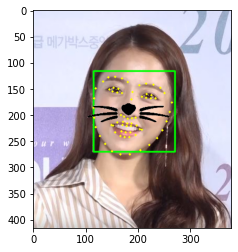

In [57]:
# 좌표 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1]
    
    w = dlib_rect.width()
    h = dlib_rect.width()
    
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))
    
# 스티커 이미지 Read
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w, h))

print (img_sticker.shape)

# 스티커 이미지 좌표
refined_x = x - w // 2  # left
refined_y = y - h // 2 # top

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

# y좌표가 음수일 때, -y만큼 이미지를 잘라준 후 y 경계값은 0으로 설정
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:]
    refined_y = 0
    
print (img_sticker.shape)
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

# 원본에 스티커 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

# 결과 이미지 출력
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 2.2.4 최종 이미지 출력 하기

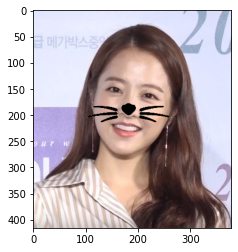

In [58]:
# 원본에 스티커 적용
sticker_area = img_bgr[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

# 결과 이미지 출력
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### 2.2.5 문제점

1번에서 적용했었던 코드를 그대로 진행 하였는데, 사진에 고양이 수염이 적용 되었습니다.

하지만, 아무래도 사진이 약간 기울어진 탓인지, 고양이 수염 이미지가 기울여진 상태로 이미지가 출력 되었습니다.

다만, 제출 기한이 있어 이 부분을 구현하지 못한 것이 아쉽습니다.

### 2.3. 반쯤 마스크를 쓴 이미지

### 2.3.1 비스듬한 각도의 이미지의 사진 불러오기

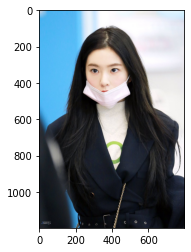

In [59]:
# opencv로 이미지 불러오기
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/mask.jfif'
img_bgr = cv2.imread(my_image_path)

# img_bgr = cv2.resize(img_bgr, (500, 500))    # 500x500의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관

# opencv 는 RGB 대신 BGR 을 사용하기 때문에 RGB로 변경
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

### 2.3.2 얼굴 검출 & 랜드마크 검출하기

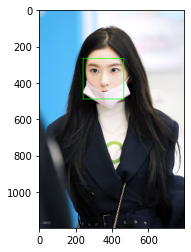

68


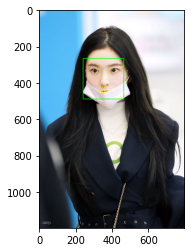

In [60]:
# HOG Detector 선언 (얼굴 위치 찾기 (Object detection))
detector_hog = dlib.get_frontal_face_detector()

# Bounding box 추출
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

# dlib_rect가 찾는 얼굴 영역 좌표
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# landmark 모델 불러오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# landmark 찾기
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0])) # landmark 갯수 확인

# landmark 출력
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### 2.3.3 스티커 적용 위치 확인하기

(355, 400)
(x,y) : (355,400)
(w,h) : (224,224)
(224, 224, 3)
(x,y) : (243,288)
(224, 224, 3)
(x,y) : (243,288)


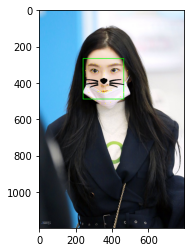

In [61]:
# 좌표 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1]
    
    w = dlib_rect.width()
    h = dlib_rect.width()
    
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))
    
# 스티커 이미지 Read
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w, h))

print (img_sticker.shape)

# 스티커 이미지 좌표
refined_x = x - w // 2  # left
refined_y = y - h // 2 # top

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

# y좌표가 음수일 때, -y만큼 이미지를 잘라준 후 y 경계값은 0으로 설정
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:]
    refined_y = 0
    
print (img_sticker.shape)
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

# 원본에 스티커 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

# 결과 이미지 출력
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 2.3.4 최종 이미지 출력 하기

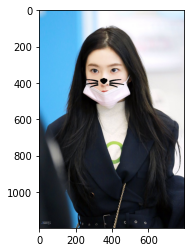

In [62]:
# 원본에 스티커 적용
sticker_area = img_bgr[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

# 결과 이미지 출력
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### 2.3.5. 결론

마스크를 쓰더라도 얼굴이 인식이 될 경우, 랜드마크와 스티커 적용이 가능함을 확인 할 수 있었습니다.

### 2.4 단체 사진

### 2.4.1 단체 사진의 이미지의 사진 불러오기

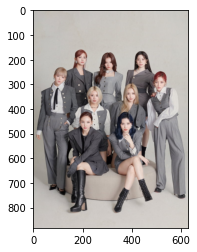

In [67]:
# opencv로 이미지 불러오기
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/group1.jpg'
img_bgr = cv2.imread(my_image_path)

# img_bgr = cv2.resize(img_bgr, (500, 500))    # 500x500의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관

# opencv 는 RGB 대신 BGR 을 사용하기 때문에 RGB로 변경
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

### 2.4.2 얼굴 검출 & 랜드마크 검출하기

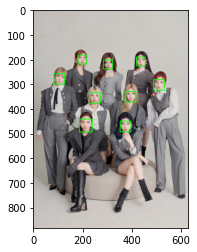

68


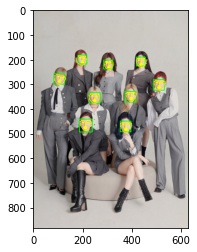

In [68]:
# HOG Detector 선언 (얼굴 위치 찾기 (Object detection))
detector_hog = dlib.get_frontal_face_detector()

# Bounding box 추출
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

# dlib_rect가 찾는 얼굴 영역 좌표
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# landmark 모델 불러오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# landmark 찾기
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0])) # landmark 갯수 확인

# landmark 출력
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### 2.4.3 스티커 적용 위치 확인하기

(249, 357)
(x,y) : (249,357)
(w,h) : (44,44)
(374, 475)
(x,y) : (374,475)
(w,h) : (44,44)
(201, 201)
(x,y) : (201,201)
(w,h) : (37,37)
(508, 305)
(x,y) : (508,305)
(w,h) : (44,44)
(211, 468)
(x,y) : (211,468)
(w,h) : (53,53)
(435, 210)
(x,y) : (435,210)
(w,h) : (37,37)
(395, 351)
(x,y) : (395,351)
(w,h) : (45,45)
(109, 279)
(x,y) : (109,279)
(w,h) : (44,44)
(305, 224)
(x,y) : (305,224)
(w,h) : (37,37)
(37, 37, 3)
(x,y) : (287,206)
(37, 37, 3)
(x,y) : (287,206)


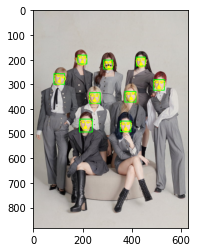

In [69]:
# 좌표 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1]
    
    w = dlib_rect.width()
    h = dlib_rect.width()
    
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))
    
# 스티커 이미지 Read
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w, h))

print (img_sticker.shape)

# 스티커 이미지 좌표
refined_x = x - w // 2  # left
refined_y = y - h // 2 # top

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

# y좌표가 음수일 때, -y만큼 이미지를 잘라준 후 y 경계값은 0으로 설정
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:]
    refined_y = 0
    
print (img_sticker.shape)
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

# 원본에 스티커 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

# 결과 이미지 출력
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 2.4.4 최종 이미지 출력 하기

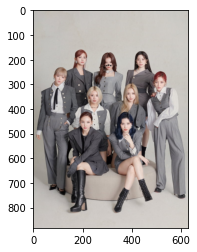

In [70]:
# 원본에 스티커 적용
sticker_area = img_bgr[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

# 결과 이미지 출력
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### 2.4.5 문제점

2.4.3 에서 스티커 적용 위치를 확인하였으나, 최종 이미지에서는 단 1명에게만 이미지가 적용 되었음을 확인 할 수 있었습니다.

아마도 모두에게 이미지를 적용할 수 있도록 반복을 하는 작업이 필요할 것으로 보입니다.

다만, 제출 기한이 있어 이 부분을 구현하지 못한 것이 아쉽습니다.

# 3. 평가 및 회고

### 3.1. 평가

1. 자기만의 카메라앱 기능 구현을 완수하였다.

   - 어두운 이미지를 제외하고는 원본에 스티커 사진이 정상적으로 합성되었습니다.

2. 스티커 이미지를 정확한 원본 위치에 반영하였다.

   - 정확한 좌표계산을 통해 고양이 수염의 위치가 원본 얼굴에 출력되기는 하였습니다.
        하지만, 비스듬하게 되어 있는 사진에서 얼굴이 회전한 만큼 수염이 회전 하지 않은 것이 아쉬웠습니다.
        
3. 카메라 스티커앱을 다양한 원본이미지에 적용했을 때의 문제점을 체계적으로 분석하였다.

   - 얼굴의 회전, 밝기, 다수의 인원 등 스티커 이미지를 붙이는데 영향을 끼칠 수 있는 요인에 대해 고려 하여 예상할 수 있는 문제를 고려해보았으나, 랜드마크를 인식을 함에도 불구하고 특정 상황 (어두운 이미지, 단체 이미지) 에서 스티커를 붙이는 것에서 오류가 발생하였습니다.

### 3.2 회고

1. 어려웠던 점

    - cv2 나 np.where 등의 모듈과 문법을 처음 사용해보는 탓에 의도한 것과 다르게 시행착오를 많이 겪었습니다.
    
    - 이후 어려웠던 부분에 대해서 스터디에서 이야기를 나누며 공유를 해보았으나, 여전히 해결하지 못한 영역이 존재합니다.
    
    - 얼굴 각도에 따라서 스티커를 회전 시켜야하는데, 이를 정확히 어떻게 수정해야하는 지에 대해서 숙지 및 적용을 하지 못하였습니다.
    
    - 어두운 이미지나 단체 이미지에서 렌드마크를 형성하는 것 까지는 진행하였으나,
        스티커의 합성이 저의 의도대로 진행 되지 못 한 것이 많이 아쉽습니다.
        우선 프로젝트 제출 기한으로 인해 완료하지 못하고 제출을 하게 되었으나,
        추후에 이 분야에 대해서 보완 후 수정을 할 예정입니다.

2. 배운 점

    - opencv는 BGR로 쓰이기에 RGB로 변환해주어야 합니다.
    - 제출 기한으로 인해 다양한 시도를 하면서 발생한 이슈를 잡아내지는 못하였으나,
        특정 이미지에서 원하는 결과물을 만들었다는 것에서 의의를 둘 예정입니다.
        
3. 마무리

    - 프로젝트를 진행하면서, 저 스스로 부족함을 많이 느끼기는 하였으나, 여러 시도를 통해서 이슈를 하나하나 해결해 나가는 즐거움을
      느끼는 계기가 되었다고 생각합니다. 추후에 이와 유사한 영역을 다시 학습할 기회가 생긴다면, 조금 더 다양한 방법으로 할 수 있는
      것들을 찾아보고, 그 과정에서 배운 노하우를 가지고 지금 해결 하지 못한 프로젝트를 보완해보고 싶습니다.